(mass)=
```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# {index}`Asset Pricing: Finite State Models <single: Asset Pricing: Finite State Models>`

```{index} single: Models; Markov Asset Pricing
```

```{contents} Contents
:depth: 2
```

```{epigraph}
"A little knowledge of geometric series goes a long way" -- Robert E. Lucas, Jr.
```

```{epigraph}
"Asset pricing is all about covariances" -- Lars Peter Hansen
```

```{admonition} GPU
:class: warning

This lecture is accelerated via [hardware](status:machine-details) that has access to a GPU and JAX for GPU programming.

Free GPUs are available on Google Colab. To use this option, please click on the play icon top right, select Colab, and set the runtime environment to include a GPU.

Alternatively, if you have your own GPU, you can follow the [instructions](https://github.com/google/jax) for installing JAX with GPU support. If you would like to install JAX running on the `cpu` only you can use `pip install jax[cpu]`
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

## Overview

```{index} single: Markov Asset Pricing; Overview
```

An asset is a claim on one or more future payoffs.

The spot price of an asset depends primarily on

* the anticipated income stream
* attitudes about risk
* rates of time preference

In this lecture, we consider some standard pricing models and dividend stream specifications.

We study how prices and dividend-price ratios respond in these different scenarios.

We also look at creating and pricing *derivative* assets that repackage income streams.

Key tools for the lecture are

* Markov processes
* formulas for predicting future values of functions of a Markov state
* a formula for predicting the discounted sum of future values of a Markov state

Let's start with some imports:

In [2]:
import matplotlib.pyplot as plt
import quantecon as qe
import jax
import jax.numpy as jnp
from jax.numpy.linalg import eigvals, solve
from jax.experimental import checkify
from typing import NamedTuple

## {index}`Pricing Models <single: Pricing Models>`

```{index} single: Models; Pricing
```

Let $\{d_t\}_{t \geq 0}$ be a stream of dividends

* A time-$t$ **cum-dividend** asset is a claim to the stream $d_t, d_{t+1}, \ldots$.
* A time-$t$ **ex-dividend** asset is a claim to the stream $d_{t+1}, d_{t+2}, \ldots$.

Let's look at some equations that we expect to hold for prices of assets under ex-dividend contracts
(we will consider cum-dividend pricing in the exercises).

### Risk-neutral pricing

```{index} single: Pricing Models; Risk-Neutral
```

Our first scenario is risk-neutral pricing.

Let $\beta = 1/(1+\rho)$ be an intertemporal discount **factor**, where
$\rho$ is the **rate** at which agents discount the future.

The basic risk-neutral asset pricing equation for pricing one unit of an ex-dividend asset is

(mass_pra)=
```{math}
:label: rnapex

p_t = \beta {\mathbb E}_t [d_{t+1} + p_{t+1}]
```

This is a simple "cost equals expected benefit" relationship.

Here ${\mathbb E}_t [y]$ denotes the best forecast of $y$, conditioned on information available at time $t$.

More precisely, ${\mathbb E}_t [y]$ is the mathematical expectation of $y$ conditional on information available at time $t$.

### Pricing with random discount factor

```{index} single: Pricing Models; Risk Aversion
```

What happens if for some reason traders discount payouts differently depending on the state of the world?

Michael Harrison and David Kreps {cite}`HarrisonKreps1979` and Lars Peter Hansen
and Scott Richard {cite}`HansenRichard1987` showed that in quite general
settings the price of an ex-dividend asset obeys

```{math}
:label: lteeqs0

p_t = {\mathbb E}_t \left[ m_{t+1}  ( d_{t+1} + p_{t+1} ) \right]
```

for some  **stochastic discount factor** $m_{t+1}$.

Here the fixed discount factor $\beta$ in {eq}`rnapex` has been replaced by the random variable $m_{t+1}$.

How anticipated future payoffs are evaluated now depends on statistical properties of $m_{t+1}$.

The stochastic discount factor can be specified to capture the idea that assets that tend to have good payoffs in bad states of the world are valued more highly than other assets whose payoffs don't behave that way.

This is because such assets pay well when funds are more urgently wanted.

We give examples of how the stochastic discount factor has been modeled below.

### Asset pricing and covariances

Recall that, from the definition of a conditional covariance ${\rm cov}_t (x_{t+1}, y_{t+1})$, we have

```{math}
:label: lteeqs101

{\mathbb E}_t (x_{t+1} y_{t+1}) = {\rm cov}_t (x_{t+1}, y_{t+1}) + {\mathbb E}_t x_{t+1} {\mathbb E}_t y_{t+1}
```

If we apply this definition to the asset pricing equation {eq}`lteeqs0` we obtain

```{math}
:label: lteeqs102

p_t = {\mathbb E}_t m_{t+1} {\mathbb E}_t (d_{t+1} + p_{t+1}) + {\rm cov}_t (m_{t+1}, d_{t+1}+ p_{t+1})
```

It is useful to regard equation {eq}`lteeqs102` as a generalization of equation {eq}`rnapex`

* In equation {eq}`rnapex`, the stochastic discount factor $m_{t+1} = \beta$, a constant.
* In equation {eq}`rnapex`, the covariance term ${\rm cov}_t (m_{t+1}, d_{t+1}+ p_{t+1})$ is zero because $m_{t+1} = \beta$.
* In equation {eq}`rnapex`, ${\mathbb E}_t m_{t+1}$ can be interpreted as the reciprocal of the one-period risk-free gross interest rate.
* When $m_{t+1}$ covaries more negatively with the payout $p_{t+1} + d_{t+1}$, the price of the asset is lower.

Equation {eq}`lteeqs102` asserts that the covariance of the stochastic discount factor with the one period payout $d_{t+1} + p_{t+1}$ is an important determinant of the price $p_t$.

We give examples of some models of stochastic discount factors that have been proposed later in this lecture and also in a {doc}`later lecture<advanced:lucas_model>`.

### The price-dividend ratio

Aside from prices, another quantity of interest is the **price-dividend ratio** $v_t := p_t / d_t$.

Let's write down an expression that this ratio should satisfy.

We can divide both sides of {eq}`lteeqs0` by $d_t$ to get

```{math}
:label: pdex

v_t = {\mathbb E}_t \left[ m_{t+1} \frac{d_{t+1}}{d_t} (1 + v_{t+1}) \right]
```

Below we'll discuss the implication of this equation.

## Prices in the risk-neutral case

What can we say about price dynamics on the basis of the models described above?

The answer to this question depends on

1. the process we specify for dividends
1. the stochastic discount factor and how it correlates with dividends

For now we'll study the risk-neutral case in which the stochastic discount factor is constant.

We'll focus on how an asset price depends on a dividend process.

### Example 1: constant dividends

The simplest case is risk-neutral price of a constant, non-random dividend stream $d_t = d > 0$.

Removing the expectation from {eq}`rnapex` and iterating forward gives

$$
\begin{aligned}
    p_t & = \beta (d + p_{t+1})
        \\
        & = \beta (d + \beta(d + p_{t+2}))
        \\
        & \quad \vdots
        \\
        & = \beta (d + \beta d + \beta^2 d +  \cdots + \beta^{k-2} d + \beta^{k-1} p_{t+k})
\end{aligned}
$$

If $\lim_{k \rightarrow + \infty} \beta^{k-1} p_{t+k} = 0$, this sequence converges to

```{math}
:label: ddet

\bar p := \frac{\beta d}{1-\beta}
```

This is the equilibrium price in the constant dividend case.

Indeed, simple algebra shows that setting $p_t = \bar p$ for all $t$
satisfies the difference equation $p_t = \beta (d + p_{t+1})$.

### Example 2: dividends with deterministic growth paths

Consider a growing, non-random dividend process $d_{t+1} = g d_t$
where $0 < g \beta < 1$.

While prices are not usually constant when dividends grow over time, a price
dividend-ratio can be.

If we guess this, substituting $v_t = v$ into {eq}`pdex` as well as our
other assumptions, we get $v = \beta g (1 + v)$.

Since $\beta g < 1$, we have a unique positive solution:

$$
v = \frac{\beta g}{1 - \beta g }
$$

The price is then

$$
p_t = \frac{\beta g}{1 - \beta g } d_t
$$

If, in this example, we take $g = 1+\kappa$ and let
$\rho := 1/\beta - 1$, then the price becomes

$$
p_t = \frac{1 + \kappa}{ \rho - \kappa} d_t
$$

This is called the *Gordon formula*.

(mass_mg)=
### Example 3: Markov growth, risk-neutral pricing

Next, we consider a dividend process

```{math}
:label: mass_fmce

d_{t+1} = g_{t+1} d_t
```

The stochastic growth factor $\{g_t\}$ is given by

$$
g_t = g(X_t), \quad t = 1, 2, \ldots
$$

where

1. $\{X_t\}$ is a finite Markov chain with state space $S$ and
   transition probabilities

   $$
   P(x, y) := \mathbb P \{ X_{t+1} = y \,|\, X_t = x \}
   \qquad (x, y \in S)
   $$

1. $g$ is a given function on $S$ taking nonnegative values

You can think of

* $S$ as $n$ possible "states of the world" and $X_t$ as the
  current state.
* $g$ as a function that maps a given state $X_t$ into a growth of dividends
  factor $g_t = g(X_t)$.
* $\ln g_t = \ln (d_{t+1} / d_t)$ is the growth rate of dividends.

(For a refresher on notation and theory for finite Markov chains see {doc}`this lecture <finite_markov>`)

The next figure shows a simulation, where

* $\{X_t\}$ evolves as a discretized AR1 process produced using {ref}`Tauchen's method <fm_ex3>`.
* $g_t = \exp(X_t)$, so that $\ln g_t = X_t$ is the growth rate.

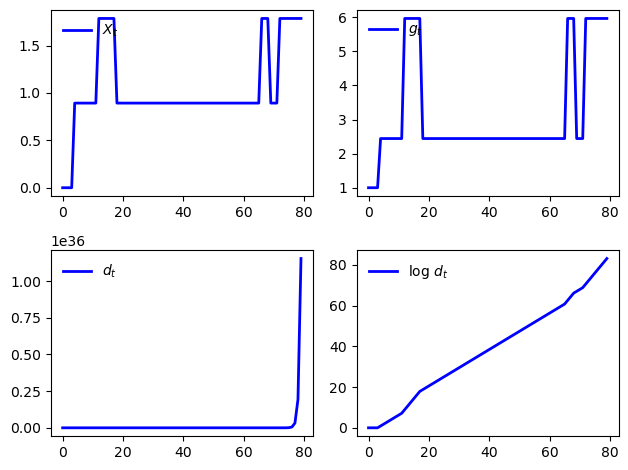

In [3]:
n = 7
mc = qe.tauchen(n, 0.96, 0.25)
sim_length = 80

x_series = mc.simulate(sim_length, init=jnp.median(mc.state_values))
g_series = jnp.exp(x_series)
d_series = jnp.cumprod(g_series) # Assumes d_0 = 1

series = [x_series, g_series, d_series, jnp.log(d_series)]
labels = ['$X_t$', '$g_t$', '$d_t$', r'$\log \, d_t$']

fig, axes = plt.subplots(2, 2)
for ax, s, label in zip(axes.flatten(), series, labels):
    ax.plot(s, 'b-', lw=2, label=label)
    ax.legend(loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

#### Pricing formula

To obtain asset prices in this setting, let's adapt our analysis from the case of deterministic growth.

In that case, we found that $v$ is constant.

This encourages us to guess that, in the current case, $v_t$ is a fixed function of the state $X_t$.

We seek a function $v$ such that the price-dividend ratio satisfies  $v_t = v(X_t)$.

We can substitute this guess into {eq}`pdex` to get

$$
v(X_t) = \beta {\mathbb E}_t [ g(X_{t+1}) (1 + v(X_{t+1})) ]
$$

If we condition on $X_t = x$, this becomes

$$
v(x) = \beta \sum_{y \in S}  g(y) (1 + v(y)) P(x, y)
$$

or

```{math}
:label: pstack

v(x) = \beta \sum_{y \in S}   K(x, y) (1 + v(y))
\quad \text{where} \quad
K(x, y) := g(y) P(x, y)
```

Suppose that there are $n$ possible states $x_1, \ldots, x_n$.

We can then think of {eq}`pstack` as $n$ stacked equations, one for each state, and write it in matrix form as

```{math}
:label: vcumrn

v = \beta K (\mathbb 1 + v)
```

Here

* $v$ is understood to be the column vector $(v(x_1), \ldots, v(x_n))'$.
* $K$ is the matrix $(K(x_i, x_j))_{1 \leq i, j \leq n}$.
* ${\mathbb 1}$ is a column vector of ones.

When does equation {eq}`vcumrn` have a unique solution?

From the {ref}`Neumann series lemma <la_neumann>` and Gelfand's formula, equation {eq}`vcumrn` has a unique solution when $\beta K$ has spectral radius strictly less than one.

Thus,  we require that the eigenvalues of $K$  be strictly less than $\beta^{-1}$ in modulus.

The solution is then

```{math}
:label: rned

v = (I - \beta K)^{-1} \beta K{\mathbb 1}
```

### Code

Let's calculate and plot the price-dividend ratio at some parameters.

As before, we'll generate $\{X_t\}$  as a {ref}`discretized AR1 process <fm_ex3>` and set $g_t = \exp(X_t)$.

Here's the code, including a test of the spectral radius condition

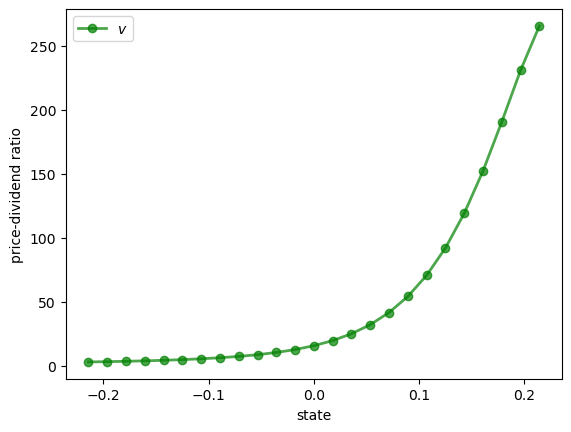

In [4]:
n = 25  # Size of state space
β = 0.9
mc = qe.tauchen(n, 0.96, 0.02)

K = mc.P * jnp.exp(mc.state_values)

warning_message = "Spectral radius condition fails"
assert jnp.max(jnp.abs(eigvals(K))) < 1 / β,  warning_message

I = jnp.identity(n)
v = solve(I - β * K, β * K @ jnp.ones(n))

fig, ax = plt.subplots()
ax.plot(mc.state_values, v, 'g-o', lw=2, alpha=0.7, label='$v$')
ax.set_ylabel("price-dividend ratio")
ax.set_xlabel("state")
ax.legend(loc='upper left')
plt.show()

Why does the price-dividend ratio increase with the state?

The reason is that this Markov process is positively correlated, so high
current states suggest high future states.

Moreover, dividend growth is increasing in the state.

The anticipation of high future dividend growth leads to a high price-dividend ratio.

## Risk Aversion and Asset Prices

Now let's turn to the case where agents are risk averse.

We'll price several distinct assets, including

* An endowment stream
* A consol (a type of bond issued by the UK government in the 19th century)
* Call options on a consol

### Pricing a Lucas tree

```{index} single: Finite Markov Asset Pricing; Lucas Tree
```

Let's start with a version of the celebrated asset pricing model of Robert E. Lucas, Jr. {cite}`Lucas1978`.

Lucas considered an abstract pure exchange economy with these features:

* a single non-storable consumption good
* a Markov process that governs the total amount of the consumption good available each period
* a single *tree* that each period yields *fruit* that equals the total amount of consumption available to the economy
* a competitive market in  *shares* in the tree that entitles their owners to corresponding shares of the *dividend* stream, i.e., the *fruit* stream, yielded by the tree

* a representative consumer who in a competitive equilibrium

    * consumes the economy's entire endowment each period
    * owns 100 percent of the shares in the tree

As in {cite}`Lucas1978`, we suppose that the stochastic discount factor takes the form

```{math}
:label: lucsdf

m_{t+1} = \beta \frac{u'(c_{t+1})}{u'(c_t)}
```

where $u$ is a concave utility function and $c_t$ is time $t$ consumption of a representative consumer.

(A derivation of this expression is given in a {doc}`later lecture<advanced:lucas_model>`)

Assume the existence of an endowment that follows growth process {eq}`mass_fmce`.

The asset being priced is a claim on the endowment process, i.e., the *Lucas tree* described above.

Following {cite}`Lucas1978`, we suppose  that in equilibrium the representative consumer's  consumption equals the aggregate endowment, so that $d_t = c_t$ for all $t$.

For utility, we'll assume the **constant relative risk aversion** (CRRA)
specification

```{math}
:label: eqCRRA

u(c) = \frac{c^{1-\gamma}}{1 - \gamma} \ {\rm with} \ \gamma > 0
```

When $\gamma =1$ we let $u(c) = \ln c$.

Inserting the CRRA specification into {eq}`lucsdf` and using $c_t = d_t$ gives

```{math}
:label: lucsdf2

m_{t+1}
= \beta \left(\frac{c_{t+1}}{c_t}\right)^{-\gamma}
= \beta g_{t+1}^{-\gamma}
```

Substituting this into {eq}`pdex` gives the price-dividend ratio
formula

$$
v(X_t)
= \beta {\mathbb E}_t
\left[
    g(X_{t+1})^{1-\gamma} (1 + v(X_{t+1}) )
\right]
$$ (eq:neweqn101)

Conditioning on $X_t = x$, we can write this as

$$
v(x)
= \beta \sum_{y \in S} g(y)^{1-\gamma} (1 + v(y) ) P(x, y)
$$

If we let

$$
J(x, y) := g(y)^{1-\gamma}  P(x, y)
$$

then we can rewrite equation {eq}`eq:neweqn101` in vector form as

$$
v = \beta J ({\mathbb 1} + v )
$$

Assuming that the spectral radius of $J$ is strictly less than $\beta^{-1}$, this equation has the unique solution

```{math}
:label: resolvent2

v = (I - \beta J)^{-1} \beta  J {\mathbb 1}
```

We will define a function `tree_price` to compute $v$ given parameters stored in
the class `AssetPriceModel`

In [5]:
class MarkovChain(NamedTuple):
    """
    A class that stores the primitives of a Markov chain.
    Parameters
    ----------
    P : jnp.ndarray
        Transition matrix
    state_values : jnp.ndarray
        The values associated with each state
    """
    P: jax.Array
    state_values: jax.Array


class AssetPriceModel(NamedTuple):
    """
    A class that stores the primitives of the asset pricing model.

    Parameters
    ----------
    mc : MarkovChain
        Contains the transition matrix and set of state values
    G : jax.Array
        The vector form of the function mapping states to growth rates
    β : float
        Discount factor
    γ : float
        Coefficient of risk aversion
    """
    mc: MarkovChain
    G: jax.Array
    β: float
    γ: float
    

def create_ap_model(g=jnp.exp, β=0.96, γ=2.0):
    """Create an AssetPriceModel class using standard Markov chain."""
    n, ρ, σ = 25, 0.9, 0.02
    qe_mc = qe.tauchen(n, ρ, σ)
    P = jnp.array(qe_mc.P)
    state_values = jnp.array(qe_mc.state_values)
    G = g(state_values)
    mc = MarkovChain(P=P, state_values=state_values)

    return AssetPriceModel(mc=mc, G=G, β=β, γ=γ)


def create_customized_ap_model(mc: MarkovChain, g=jnp.exp, β=0.96, γ=2.0):
    """Create an AssetPriceModel class using a customized Markov chain."""
    G = g(mc.state_values)
    return AssetPriceModel(mc=mc, G=G, β=β, γ=γ)


def test_stability(Q, β):
    """Stability test for a given matrix Q."""
    sr = jnp.max(jnp.abs(eigvals(Q)))
    checkify.check(
        sr < 1 / β, 
        "Spectral radius condition failed with radius = {sr}", sr=sr
        )
    return sr


def tree_price(ap):
    """
    Computes the price-dividend ratio of the Lucas tree.

    Parameters
    ----------
    ap: AssetPriceModel
        An instance of AssetPriceModel containing primitives

    Returns
    -------
    v : array_like(float)
        Lucas tree price-dividend ratio
    """
    # Simplify names, set up matrices
    β, γ, P, G = ap.β, ap.γ, ap.mc.P, ap.G
    J = P * G**(1 - γ)

    # Make sure that a unique solution exists
    test_stability(J, β)

    # Compute v
    n = J.shape[0]
    I = jnp.identity(n)
    Ones = jnp.ones(n)
    v = solve(I - β * J, β * J @ Ones)

    return v

# Wrap the function to be safely jitted
tree_price_jit = jax.jit(checkify.checkify(tree_price))

Here's a plot of $v$ as a function of the state for several values of $\gamma$,
with a positively correlated Markov process and $g(x) = \exp(x)$

Compute price-dividend ratio of Lucas tree:: 0.37 ms elapsed
Compute price-dividend ratio of Lucas tree:: 0.08 ms elapsed
Compute price-dividend ratio of Lucas tree:: 0.04 ms elapsed
Compute price-dividend ratio of Lucas tree:: 0.05 ms elapsed
Compute price-dividend ratio of Lucas tree:: 0.05 ms elapsed


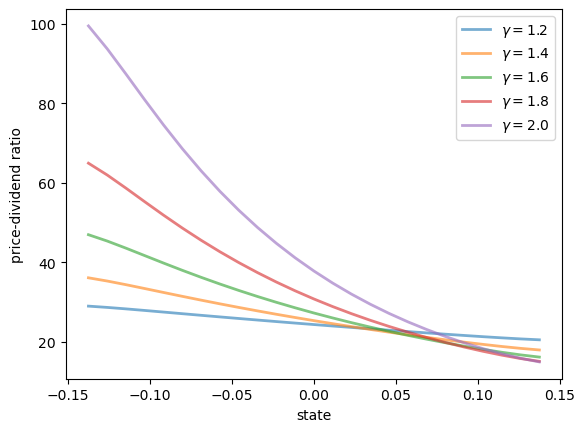

In [ ]:
γs = [1.2, 1.4, 1.6, 1.8, 2.0]
ap = create_ap_model()
states = ap.mc.state_values

fig, ax = plt.subplots()

for γ in γs:
    tem_ap = create_customized_ap_model(ap.mc, γ=γ)
    # checkify returns a tuple
    # err indicates whether errors happened
    err, v = tree_price_jit(tem_ap)
    # Stop if errors raised
    err.throw()
    ax.plot(states, v, lw=2, alpha=0.6, label=rf"$\gamma = {γ}$")

ax.set_ylabel("price-dividend ratio")
ax.set_xlabel("state")
ax.legend(loc='upper right')
plt.show()

Notice that $v$ is decreasing in each case.

This is because, with a positively correlated state process, higher states indicate higher future consumption growth.

With the stochastic discount factor {eq}`lucsdf2`, higher growth decreases the
discount factor, lowering the weight placed on future dividends.

#### Special Cases

In the special case $\gamma =1$, we have $J = P$.

Recalling that $P^i {\mathbb 1} = {\mathbb 1}$ for all $i$ and applying {ref}`Neumann's geometric series lemma <la_neumann>`, we are led to

$$
v = \beta(I-\beta P)^{-1} {\mathbb 1}
= \beta \sum_{i=0}^{\infty} \beta^i P^i {\mathbb 1}
= \beta \frac{1}{1 - \beta} {\mathbb 1}
$$

Thus, with log preferences, the price-dividend ratio for a Lucas tree is constant.

Alternatively, if $\gamma = 0$, then $J = K$ and we recover the
risk-neutral solution {eq}`rned`.

This is as expected, since $\gamma = 0$ implies $u(c) = c$ (and hence agents are risk-neutral).

### A Risk-Free Consol

Consider the same pure exchange representative agent economy.

A risk-free consol promises to pay a constant amount  $\zeta> 0$ each period.

Recycling notation, let $p_t$ now be the price of an  ex-coupon claim to the consol.

An ex-coupon claim to the consol entitles an owner at the end of period $t$ to

* $\zeta$ in period $t+1$, plus
* the right to sell the claim for $p_{t+1}$ next period

The price satisfies {eq}`lteeqs0` with $d_t = \zeta$, or

$$
p_t = {\mathbb E}_t \left[ m_{t+1}  ( \zeta + p_{t+1} ) \right]
$$

With the stochastic discount factor {eq}`lucsdf2`, this becomes

```{math}
:label: consolguess1

p_t
= {\mathbb E}_t \left[ \beta g_{t+1}^{-\gamma}  ( \zeta + p_{t+1} ) \right]
```

Guessing a solution of the form $p_t = p(X_t)$ and conditioning on
$X_t = x$, we get

$$
p(x)
= \beta \sum_{y \in S}  g(y)^{-\gamma} (\zeta + p(y)) P(x, y)
$$

Letting $M(x, y) = P(x, y) g(y)^{-\gamma}$ and rewriting in vector notation
yields the solution

```{math}
:label: consol_price

p = (I - \beta M)^{-1} \beta M \zeta {\mathbb 1}
```

The above is implemented in the function `consol_price`.

In [7]:
def consol_price(ap, ζ):
    """
    Computes price of a consol bond with payoff ζ

    Parameters
    ----------
    ap: AssetPriceModel
        An instance of AssetPriceModel containing primitives
    
    ζ : scalar(float)
        Coupon of the console

    Returns
    -------
    p : array_like(float)
        Console bond prices
    """
    # Simplify names, set up matrices
    β, γ, P, G = ap.β, ap.γ, ap.mc.P, ap.G
    M = P * G**(- γ)

    # Make sure that a unique solution exists
    test_stability(M, β)

    # Compute price
    n = M.shape[0]
    I = jnp.identity(n)
    Ones = jnp.ones(n)
    p = solve(I - β * M, β * ζ * M @ Ones)

    return p

# Wrap the function to be safely jitted
consol_price_jit = jax.jit(checkify.checkify(consol_price))

### Pricing an Option to Purchase the Consol

Let's now price options of various maturities.

We'll study an option that  gives the owner the  right to purchase a consol at a price $p_S$.

#### An Infinite Horizon Call Option

We want to price an *infinite horizon*  option to purchase a consol at a price $p_S$.

The option entitles the owner at the beginning of a period either

1. to purchase the bond at price $p_S$ now, or
1. not to exercise the option to purchase the asset now but to retain the right to exercise it later

Thus, the owner either *exercises* the option now or chooses *not to exercise* and wait until next period.

This is termed an infinite-horizon *call option* with *strike price* $p_S$.

The owner of the option is entitled to purchase the consol at  price $p_S$ at the beginning of any period, after the coupon has been paid to the previous owner of the bond.

The fundamentals of the economy are identical with the one above, including the stochastic discount factor and the process for consumption.

Let $w(X_t, p_S)$ be the value of the option when the time $t$ growth state is known to be $X_t$ but *before* the owner has decided whether to exercise the option
at time $t$ (i.e., today).

Recalling that $p(X_t)$ is the value of the consol when the initial growth state is $X_t$, the value of the option satisfies

$$
w(X_t, p_S)
= \max \left\{
    \beta \, {\mathbb E}_t \frac{u'(c_{t+1})}{u'(c_t)} w(X_{t+1}, p_S), \;
         p(X_t) - p_S
\right\}
$$

The first term on the right is the value of waiting, while the second is the value of exercising now.

We can also write this as

```{math}
:label: FEoption0

w(x, p_S)
= \max \left\{
    \beta \sum_{y \in S} P(x, y) g(y)^{-\gamma}
    w (y, p_S), \;
    p(x) - p_S
\right\}
```

With $M(x, y) = P(x, y) g(y)^{-\gamma}$ and $w$ as the vector of
values $(w(x_i), p_S)_{i = 1}^n$, we can express {eq}`FEoption0` as the nonlinear vector equation

```{math}
:label: FEoption

w = \max \{ \beta M w, \; p - p_S {\mathbb 1} \}
```

To solve {eq}`FEoption`, form an operator $T$ that maps vector $w$
into vector $Tw$ via

$$
T w
= \max \{ \beta M w,\; p - p_S {\mathbb 1} \}
$$

Start at some initial $w$ and iterate with $T$ to convergence.

We can find the solution with the following function `call_option`

In [8]:
def call_option(ap, ζ, p_s, ϵ=1e-7):
    """
    Computes price of a call option on a consol bond.

    Parameters
    ----------
    ap: AssetPriceModel
        An instance of AssetPriceModel containing primitives

    ζ : scalar(float)
        Coupon of the console

    p_s : scalar(float)
        Strike price

    ϵ : scalar(float), optional(default=1e-7)
        Tolerance for infinite horizon problem

    Returns
    -------
    w : array_like(float)
        Infinite horizon call option prices

    """
    # Simplify names, set up matrices
    β, γ, P, G = ap.β, ap.γ, ap.mc.P, ap.G
    M = P * G**(- γ)

    # Make sure that a unique consol price exists
    test_stability(M, β)

    # Compute option price
    p = consol_price(ap, ζ)
    err.throw()
    n = M.shape[0]
    w = jnp.zeros(n)
    error = ϵ + 1

    def step(state):
        w, _ = state
        # Maximize across columns
        w_new = jnp.maximum(β * M @ w, p - p_s)
        # Find maximal difference of each component and update
        error_new = jnp.amax(jnp.abs(w - w_new))
        return (w_new, error_new)

    # Check whether converged
    def cond(state):
        _, error = state
        return error > ϵ

    final_w, _ = jax.lax.while_loop(cond, step, (w, error))

    return final_w

call_option_jit = jax.jit(checkify.checkify(call_option))

Here's a plot of $w$ compared to the consol price when $P_S = 40$

Compute consol price Jit: 0.20 ms elapsed
Compute call option price: 0.21 ms elapsed


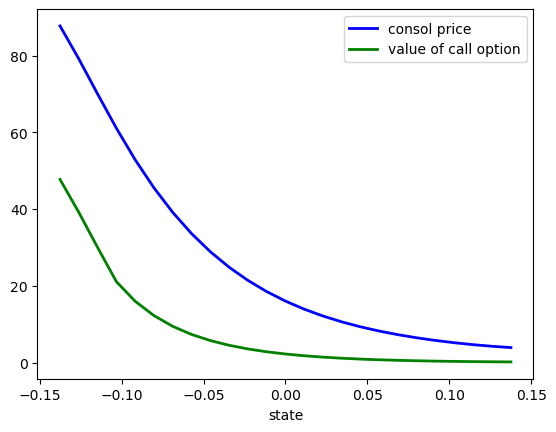

In [ ]:
ap = create_ap_model(β=0.9)
ζ = 1.0
strike_price = 40

x = ap.mc.state_values
err, p = consol_price_jit(ap, ζ)
err.throw()
err, w = call_option_jit(ap, ζ, strike_price)
err.throw()

fig, ax = plt.subplots()
ax.plot(x, p, 'b-', lw=2, label='consol price')
ax.plot(x, w, 'g-', lw=2, label='value of call option')
ax.set_xlabel("state")
ax.legend(loc='upper right')
plt.show()

In high values of the Markov growth state, the value of the option is close to zero.

This is despite the facts that the Markov chain is irreducible and that low states ---
where the consol prices are high --- will be visited recurrently.

The reason for low valuations in high Markov growth states is that $\beta=0.9$, so  future payoffs are  discounted substantially.

### Risk-Free Rates

Let's look at risk-free interest rates over different periods.

#### The One-period Risk-free Interest Rate

As before, the stochastic discount factor is $m_{t+1} = \beta g_{t+1}^{-\gamma}$.

It follows that the reciprocal $R_t^{-1}$ of the gross risk-free interest rate $R_t$ in state $x$ is

$$
{\mathbb E}_t m_{t+1} = \beta \sum_{y \in S} P(x, y) g(y)^{-\gamma}
$$

We can write this as

$$
m_1 = \beta M {\mathbb 1}
$$

where the $i$-th  element of $m_1$ is the reciprocal of the one-period gross risk-free interest rate in state $x_i$.

#### Other Terms

Let $m_j$ be an $n \times 1$ vector whose $i$ th component is the reciprocal of the $j$ -period gross risk-free interest rate in state $x_i$.

Then $m_1 = \beta M$, and $m_{j+1} = M m_j$ for $j \geq 1$.

## Exercises

```{exercise}
:label: ma_ex1

In the lecture, we considered **ex-dividend assets**.

A **cum-dividend** asset is a claim to the stream $d_t, d_{t+1}, \ldots$.

Following {eq}`rnapex`, find the risk-neutral asset pricing equation for
one unit of a cum-dividend asset.

With a constant, non-random dividend stream $d_t = d > 0$, what is the equilibrium
price of a cum-dividend asset?

With a growing, non-random dividend process $d_t = g d_t$ where $0 < g \beta < 1$,
what is the equilibrium price of a cum-dividend asset?
```

```{solution} ma_ex1
:class: dropdown

For a cum-dividend asset, the basic risk-neutral asset pricing equation is

$$
p_t = d_t + \beta {\mathbb E}_t [ p_{t+1} ]
$$

(mass_ex1)=
With constant dividends, the equilibrium price is

$$
p_t = \frac{1}{1-\beta} d_t
$$

With a growing, non-random dividend process, the equilibrium price is

$$
p_t = \frac{1}{1 - \beta g} d_t
$$
```

```{exercise-start}
:label: ma_ex2
```

Consider the following primitives

In [10]:
n = 5  # Size of State Space
P = jnp.full((n, n), 0.0125)
P = P.at[jnp.arange(n), jnp.arange(n)].set(
    P[jnp.arange(n), jnp.arange(n)] + 1 - P.sum(1)
    )
# State values of the Markov chain
s = jnp.array([0.95, 0.975, 1.0, 1.025, 1.05])
γ = 2.0
β = 0.94

Let $g$ be defined by $g(x) = x$  (that is, $g$ is the identity map).

Compute the price of the Lucas tree.

Do the same for

* the price of the risk-free consol when $\zeta = 1$
* the call option on the consol when $\zeta = 1$ and $p_S = 150.0$

```{exercise-end}
```

```{solution-start} ma_ex2
:class: dropdown
```

First, let's enter the parameters:

In [11]:
n = 5
P = jnp.full((n, n), 0.0125)
P = P.at[jnp.arange(n), jnp.arange(n)].set(
    P[jnp.arange(n), jnp.arange(n)] + 1 - P.sum(1)
    )
s = jnp.array([0.95, 0.975, 1.0, 1.025, 1.05])  # State values
mc = MarkovChain(P=P, state_values=s)

γ = 2.0
β = 0.94
ζ = 1.0
p_s = 150.0

Next, we'll create an instance of `AssetPriceModel` to feed into the
functions

In [12]:
apm = create_customized_ap_model(mc=mc, g=lambda x: x, β=β, γ=γ)

Now we just need to call the relevant functions on the data:

In [13]:
err, v = tree_price_jit(apm)
err.throw()
print(v)

[29.474087 21.935726 17.571445 14.72517  12.72224 ]


In [14]:
err, p = consol_price_jit(apm, ζ)
err.throw()
print(p)

[753.92316 242.56683 148.68501 109.25806  87.57421]


In [15]:
err, w = call_option_jit(apm, ζ, p_s)
err.throw()
print(w)

[603.92316  176.8546   108.686775  80.05874   64.31402 ]


Let's show the last two functions as a plot

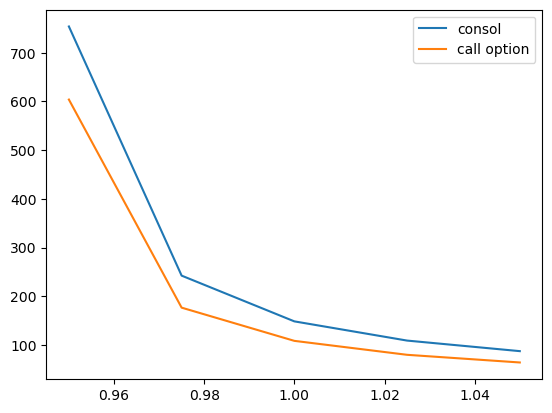

In [16]:
fig, ax = plt.subplots()
ax.plot(s, p, label='consol')
ax.plot(s, w, label='call option')
ax.legend()
plt.show()

```{solution-end}
```

```{exercise}
:label: ma_ex3

Let's consider finite horizon call options, which are more common than
infinite horizon ones.

Finite horizon options obey functional equations closely related to {eq}`FEoption0`.

A $k$ period option expires after $k$ periods.

If we view today as date zero, a $k$ period option gives the owner the right to exercise the option to purchase the risk-free consol at the strike price $p_S$ at dates $0, 1, \ldots , k-1$.

The option expires at time $k$.

Thus, for $k=1, 2, \ldots$, let $w(x, k)$ be the value of a $k$-period option.

It obeys

$$
w(x, k)
= \max \left\{
    \beta \sum_{y \in S} P(x, y) g(y)^{-\gamma}
    w (y, k-1), \;
    p(x) - p_S
\right\}
$$

where $w(x, 0) = 0$ for all $x$.

We can express this  as a sequence of nonlinear vector equations

$$
w_k = \max \{ \beta M w_{k-1}, \; p - p_S {\mathbb 1} \}
  \quad k =1, 2, \ldots
  \quad \text{with } w_0 = 0
$$

Write a function that computes $w_k$ for any given $k$.

Compute the value of the option with `k = 5` and `k = 25` using parameter values as in {ref}`ma_ex1`.

Is one higher than the other?  Can you give intuition?
```

```{solution-start} ma_ex3
:class: dropdown
```

Here's a suitable function:

In [17]:
def finite_call_option(ap, ζ, p_s, k):
    """
    Computes k period option value.
    """
    # Simplify names, set up matrices
    β, γ, P, G = ap.β, ap.γ, ap.mc.P, ap.G
    M = P * G**(- γ)

    # Make sure that a unique solution exists
    test_stability(M, β)

    # Compute option price
    p = consol_price(ap, ζ)
    n = M.shape[0]
    def step(i, w):
        # Maximize across columns
        w = jnp.maximum(β * M @ w, p - p_s)
        return w
    
    w = jax.lax.fori_loop(0, k, step, jnp.zeros(n))

    return w

finite_call_option_jit = jax.jit(
    checkify.checkify(finite_call_option)
    )

Now let's compute the option values at `k=5` and `k=25`

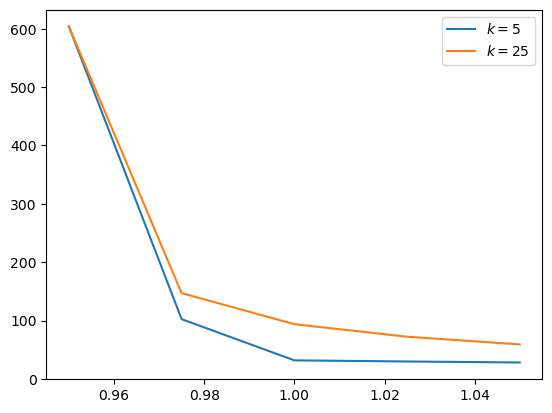

In [18]:
fig, ax = plt.subplots()
for k in [5, 25]:
    err, w = finite_call_option_jit(apm, ζ, p_s, k)
    err.throw()
    ax.plot(s, w, label=rf'$k = {k}$')
ax.legend()
plt.show()

Not surprisingly,  options with larger $k$ are worth more.

This is because an owner has a longer  horizon over which
 the option can be exercised.

```{solution-end}
```